In [36]:
import librosa
import numpy as np
import torch
import torch.nn.functional as F
from librosa.filters import mel as librosa_mel_fn
from librosa.util import pad_center, tiny
from scipy.signal import get_window
from torch.autograd import Variable


def window_sumsquare(window, n_frames, hop_length=200, win_length=800, n_fft=800, dtype=np.float32, norm=None):
    """
    # from librosa 0.6
    Compute the sum-square envelope of a window function at a given hop length.
    This is used to estimate modulation effects induced by windowing
    observations in short-time fourier transforms.
    Parameters
    ----------
    window : string, tuple, number, callable, or list-like
        Window specification, as in `get_window`
    n_frames : int > 0
        The number of analysis frames
    hop_length : int > 0
        The number of samples to advance between frames
    win_length : [optional]
        The length of the window function.  By default, this matches `n_fft`.
    n_fft : int > 0
        The length of each analysis frame.
    dtype : np.dtype
        The data type of the output
    Returns
    -------
    wss : np.ndarray, shape=`(n_fft + hop_length * (n_frames - 1))`
        The sum-squared envelope of the window function
    """
    if win_length is None:
        win_length = n_fft

    n = n_fft + hop_length * (n_frames - 1)
    x = np.zeros(n, dtype=dtype)

    # Compute the squared window at the desired length
    win_sq = get_window(window, win_length, fftbins=True)
    win_sq = librosa.util.normalize(win_sq, norm=norm)**2
    win_sq = librosa.util.pad_center(win_sq, n_fft)

    # Fill the envelope
    for i in range(n_frames):
        sample = i * hop_length
        x[sample:min(n, sample + n_fft)] += win_sq[:max(0, min(n_fft, n - sample))]
    return x


def griffin_lim(magnitudes, stft_fn, n_iters=30):
    """
    PARAMS
    ------
    magnitudes: spectrogram magnitudes
    stft_fn: STFT class with transform (STFT) and inverse (ISTFT) methods
    """

    angles = np.angle(np.exp(2j * np.pi * np.random.rand(*magnitudes.size())))
    angles = angles.astype(np.float32)
    angles = torch.autograd.Variable(torch.from_numpy(angles))
    signal = stft_fn.inverse(magnitudes, angles).squeeze(1)

    for i in range(n_iters):
        _, angles = stft_fn.transform(signal)
        signal = stft_fn.inverse(magnitudes, angles).squeeze(1)
    return signal


def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression(x, C=1):
    """
    PARAMS
    ------
    C: compression factor used to compress
    """
    return torch.exp(x) / C


class STFT(torch.nn.Module):
    """adapted from Prem Seetharaman's https://github.com/pseeth/pytorch-stft"""
    def __init__(self, filter_length=800, hop_length=200, win_length=800, window='hann', device='cpu'):
        super(STFT, self).__init__()

        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.forward_transform = None
        self.device = device
        scale = self.filter_length / self.hop_length
        fourier_basis = np.fft.fft(np.eye(self.filter_length))

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]), np.imag(fourier_basis[:cutoff, :])])

        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])
        inverse_basis = torch.FloatTensor(np.linalg.pinv(scale * fourier_basis).T[:, None, :])

        if window is not None:
            assert (filter_length >= win_length)
            # get window and zero center pad it to filter_length
            fft_window = get_window(window, win_length, fftbins=True)
            fft_window = pad_center(fft_window, filter_length)
            fft_window = torch.from_numpy(fft_window).float()

            # window the bases
            forward_basis *= fft_window
            inverse_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())
        self.register_buffer('inverse_basis', inverse_basis.float())

    def transform(self, input_data):
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)

        self.num_samples = num_samples

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)
        input_data = F.pad(input_data.unsqueeze(1), (int(self.filter_length / 2), int(self.filter_length / 2), 0, 0),
                           mode='reflect')
        input_data = input_data.squeeze(1)

        # https://github.com/NVIDIA/tacotron2/issues/125
        forward_transform = F.conv1d(input_data.to(self.device),
                                     Variable(self.forward_basis, requires_grad=False).to(self.device),
                                     stride=self.hop_length,
                                     padding=0).cpu()

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude = torch.sqrt(real_part**2 + imag_part**2)
        phase = torch.autograd.Variable(torch.atan2(imag_part.data, real_part.data))

        return magnitude, phase

    def inverse(self, magnitude, phase):
        recombine_magnitude_phase = torch.cat([magnitude * torch.cos(phase), magnitude * torch.sin(phase)], dim=1)

        inverse_transform = F.conv_transpose1d(recombine_magnitude_phase,
                                               Variable(self.inverse_basis, requires_grad=False),
                                               stride=self.hop_length,
                                               padding=0)

        if self.window is not None:
            window_sum = window_sumsquare(self.window,
                                          magnitude.size(-1),
                                          hop_length=self.hop_length,
                                          win_length=self.win_length,
                                          n_fft=self.filter_length,
                                          dtype=np.float32)
            # remove modulation effects
            approx_nonzero_indices = torch.from_numpy(np.where(window_sum > tiny(window_sum))[0])
            window_sum = torch.autograd.Variable(torch.from_numpy(window_sum), requires_grad=False)
            window_sum = window_sum.to(self.device) if magnitude.is_cuda else window_sum
            inverse_transform[:, :, approx_nonzero_indices] /= window_sum[approx_nonzero_indices]

            # scale by hop ratio
            inverse_transform *= float(self.filter_length) / self.hop_length

        inverse_transform = inverse_transform[:, :, int(self.filter_length / 2):]
        inverse_transform = inverse_transform[:, :, :-int(self.filter_length / 2):]

        return inverse_transform

    def forward(self, input_data):
        self.magnitude, self.phase = self.transform(input_data)
        reconstruction = self.inverse(self.magnitude, self.phase)
        return reconstruction

In [3]:
class TacotronSTFT(torch.nn.Module):
    def __init__(self,
                 filter_length=1024,
                 hop_length=256,
                 win_length=1024,
                 n_mel_channels=80,
                 sampling_rate=22050,
                 mel_fmin=0.0,
                 mel_fmax=None,
                 device='cpu'):
        super(TacotronSTFT, self).__init__()
        self.n_mel_channels = n_mel_channels
        self.sampling_rate = sampling_rate
        self.stft_fn = STFT(filter_length, hop_length, win_length, device=device)
        mel_basis = librosa_mel_fn(sampling_rate, filter_length, n_mel_channels, mel_fmin, mel_fmax)
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer('mel_basis', mel_basis)

    def spectral_normalize(self, magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output

    def spectral_de_normalize(self, magnitudes):
        output = dynamic_range_decompression(magnitudes)
        return output

    def mel_spectrogram(self, y):
        """Computes mel-spectrograms from a batch of waves
        PARAMS
        ------
        y: Variable(torch.FloatTensor) with shape (B, T) in range [-1, 1]
        RETURNS
        -------
        mel_output: torch.FloatTensor of shape (B, n_mel_channels, T)
        """
        assert (torch.min(y.data) >= -1)
        assert (torch.max(y.data) <= 1)

        magnitudes, phases = self.stft_fn.transform(y)
        magnitudes = magnitudes.data
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = self.spectral_normalize(mel_output)
        return mel_output


In [37]:
import os
import glob
import tqdm
import torch
import argparse
import numpy as np
from scipy.io.wavfile import read
import librosa
import yaml

In [38]:
#logger = get_logger()


def read_wav_np(path):
    sr, wav = read(path)
    if len(wav.shape) == 2:
        wav = wav[:, 0]
    if wav.dtype == np.int16:
        wav = wav / 32768.0
    elif wav.dtype == np.int32:
        wav = wav / 2147483648.0
    elif wav.dtype == np.uint8:
        wav = (wav - 128) / 128.0
    wav = wav.astype(np.float32)
    return sr, wav


if __name__ == '__main__':

    #parser = argparse.ArgumentParser()
    #parser.add_argument('-c', '--config', type=str, required=True,
                       #help="yaml file for config.")
    #parser.add_argument('-w', '--wav_path', type=str, required=True,
                        #help="root directory of wav files")
    #parser.add_argument('-m', '--mel_path', type=str, required=True,
                        #help="root directory of mel files")
    #parser.add_argument('-d', '--device', type=str, required=False,
                        #help="device, cpu or cuda:0, cuda:1,...")
    #parser.add_argument('-r', '--resample_mode', type=str, required=False, default='kaiser_fast',
                        #help="use kaiser_best for high-quality audio")

    #args = parser.parse_args()
    #logger.info(f'using resample mode {args.resample_mode}')
    #with open(args.config) as f:
    config = {'fbank':
              { 'sample_rate': 22050,
                'n_fft': 1024,
                'hop_length': 256,
                'win_length': 1024,
                'max_wav_value': 32768.0,
                'n_mels': 80,
                'fmin': 0.0,
                'fmax': 8000.0, # should be 11025 ?
                'mel_mean': -6.0304103}}

  
    #logger.info('loading TacotronSTFT')
    stft = TacotronSTFT(filter_length=config['fbank']['n_fft'],
                        hop_length=config['fbank']['hop_length'],
                        win_length=config['fbank']['win_length'],
                        n_mel_channels=config['fbank']['n_mels'],
                        sampling_rate=config['fbank']['sample_rate'],
                        mel_fmin=config['fbank']['fmin'],
                        mel_fmax=config['fbank']['fmax'],
                        device='cpu')

    #logger.info('done')
    wav_files = glob.glob(os.path.join(
      'test_files', '*.wav'), recursive=False)
    #logger.info(f'{len(wav_files)} found in {args.wav_path}')
    mel_path = 'test_mel_files'
    #logger.info(f'mel files will be saved to {mel_path}')

    # Create all folders
    os.makedirs(mel_path, exist_ok=True)
    for wavpath in tqdm.tqdm(wav_files, desc='preprocess wav to mel'):
        wav, r = librosa.load(
            wavpath, sr=config['fbank']['sample_rate'], res_type='kaiser_fast')
        wav = torch.from_numpy(wav).unsqueeze(0)
        mel = stft.mel_spectrogram(wav)  # mel [1, num_mel, T]

        mel = mel.squeeze(0)  # [num_mel, T]
        id = os.path.basename(wavpath).split(".")[0]
        np.save('{}/{}.npy'.format(mel_path, id),
                mel.numpy(), allow_pickle=False)


preprocess wav to mel: 100%|██████████| 3/3 [00:00<00:00, 19.69it/s]


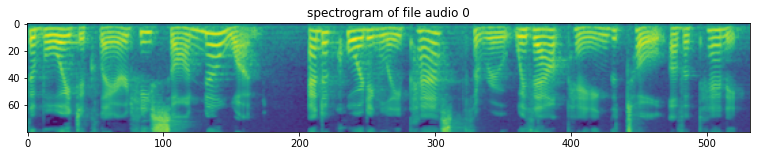

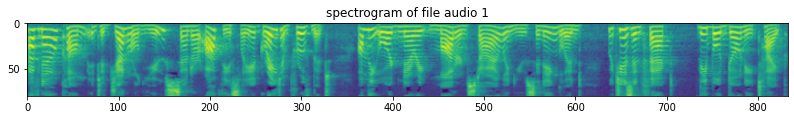

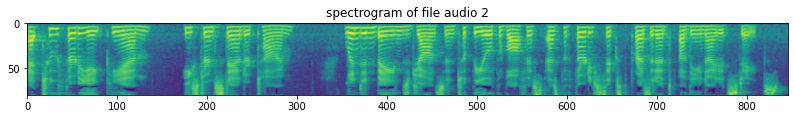

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
for index,a in enumerate(os.listdir('test_mel_files')):
  a = os.path.join('test_mel_files',str(a))
  b = np.load(a)
  plt.figure()
  plt.gcf().set_size_inches(30, 2)
  plt.subplot(1, 2, 1)
  plt.title("spectrogram of file audio {}".format(index))
  plt.imshow(b, cmap='viridis')

In [40]:
config_v1 = {
    "resblock": "1",
    "num_gpus": 0,
    "batch_size": 16,
    "learning_rate": 0.0002,
    "adam_b1": 0.8,
    "adam_b2": 0.99,
    "lr_decay": 0.999,
    "seed": 1234,

    "upsample_rates": [8,8,2,2],
    "upsample_kernel_sizes": [16,16,4,4],
    "upsample_initial_channel": 512,
    "resblock_kernel_sizes": [3,7,11],
    "resblock_dilation_sizes": [[1,3,5], [1,3,5], [1,3,5]],

    "segment_size": 8192,
    "num_mels": 80,
    "num_freq": 1025,
    "n_fft": 1024,
    "hop_size": 256,
    "win_size": 1024,

    "sampling_rate": 22050,

    "fmin": 0,
    "fmax": 8000,
    "fmax_for_loss": None,

    "num_workers": 4,

    "dist_config": {
        "dist_backend": "nccl",
        "dist_url": "tcp://localhost:54321",
        "world_size": 1
    }
}

In [41]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [42]:
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import os
import numpy as np
import argparse
import json
import torch
from scipy.io.wavfile import write


In [43]:
import glob
import os
import matplotlib
import torch
from torch.nn.utils import weight_norm
matplotlib.use("Agg")
import matplotlib.pylab as plt


def plot_spectrogram(spectrogram):
    fig, ax = plt.subplots(figsize=(10, 2))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)

    fig.canvas.draw()
    plt.close()

    return fig


def init_weights(m, mean=0.0, std=0.01):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean, std)


def apply_weight_norm(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        weight_norm(m)


def get_padding(kernel_size, dilation=1):
    return int((kernel_size*dilation - dilation)/2)


def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict


def save_checkpoint(filepath, obj):
    print("Saving checkpoint to {}".format(filepath))
    torch.save(obj, filepath)
    print("Complete.")


def scan_checkpoint(cp_dir, prefix):
    pattern = os.path.join(cp_dir, prefix + '????????')
    cp_list = glob.glob(pattern)
    if len(cp_list) == 0:
        return None
    return sorted(cp_list)[-1]

In [44]:
MAX_WAV_VALUE = 32768.0

In [45]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Conv1d, ConvTranspose1d, AvgPool1d, Conv2d
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm

LRELU_SLOPE = 0.1


class ResBlock1(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3, 5)):
        super(ResBlock1, self).__init__()
        self.h = h
        self.convs1 = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[2],
                               padding=get_padding(kernel_size, dilation[2])))
        ])
        self.convs1.apply(init_weights)

        self.convs2 = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1)))
        ])
        self.convs2.apply(init_weights)

    def forward(self, x):
        for c1, c2 in zip(self.convs1, self.convs2):
            xt = F.leaky_relu(x, LRELU_SLOPE)
            xt = c1(xt)
            xt = F.leaky_relu(xt, LRELU_SLOPE)
            xt = c2(xt)
            x = xt + x
        return x

    def remove_weight_norm(self):
        for l in self.convs1:
            remove_weight_norm(l)
        for l in self.convs2:
            remove_weight_norm(l)


class ResBlock2(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3)):
        super(ResBlock2, self).__init__()
        self.h = h
        self.convs = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1])))
        ])
        self.convs.apply(init_weights)

    def forward(self, x):
        for c in self.convs:
            xt = F.leaky_relu(x, LRELU_SLOPE)
            xt = c(xt)
            x = xt + x
        return x

    def remove_weight_norm(self):
        for l in self.convs:
            remove_weight_norm(l)


class Generator(torch.nn.Module):
    def __init__(self, h):
        super(Generator, self).__init__()
        self.h = h
        self.num_kernels = len(h.resblock_kernel_sizes)
        self.num_upsamples = len(h.upsample_rates)
        self.conv_pre = weight_norm(Conv1d(80, h.upsample_initial_channel, 7, 1, padding=3))
        resblock = ResBlock1 if h.resblock == '1' else ResBlock2

        self.ups = nn.ModuleList()
        for i, (u, k) in enumerate(zip(h.upsample_rates, h.upsample_kernel_sizes)):
            self.ups.append(weight_norm(
                ConvTranspose1d(h.upsample_initial_channel//(2**i), h.upsample_initial_channel//(2**(i+1)),
                                k, u, padding=(k-u)//2)))

        self.resblocks = nn.ModuleList()
        for i in range(len(self.ups)):
            ch = h.upsample_initial_channel//(2**(i+1))
            for j, (k, d) in enumerate(zip(h.resblock_kernel_sizes, h.resblock_dilation_sizes)):
                self.resblocks.append(resblock(h, ch, k, d))

        self.conv_post = weight_norm(Conv1d(ch, 1, 7, 1, padding=3))
        self.ups.apply(init_weights)
        self.conv_post.apply(init_weights)

    def forward(self, x):
        x = self.conv_pre(x)
        for i in range(self.num_upsamples):
            x = F.leaky_relu(x, LRELU_SLOPE)
            x = self.ups[i](x)
            xs = None
            for j in range(self.num_kernels):
                if xs is None:
                    xs = self.resblocks[i*self.num_kernels+j](x)
                else:
                    xs += self.resblocks[i*self.num_kernels+j](x)
            x = xs / self.num_kernels
        x = F.leaky_relu(x)
        x = self.conv_post(x)
        x = torch.tanh(x)

        return x

    def remove_weight_norm(self):
        print('Removing weight norm...')
        for l in self.ups:
            remove_weight_norm(l)
        for l in self.resblocks:
            l.remove_weight_norm()
        remove_weight_norm(self.conv_pre)
        remove_weight_norm(self.conv_post)


In [46]:
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict


def scan_checkpoint(cp_dir, prefix):
    pattern = os.path.join(cp_dir, prefix + '*')
    cp_list = glob.glob(pattern)
    if len(cp_list) == 0:
        return ''
    return sorted(cp_list)[-1]


def inference():
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint('pretrained_model/LJ_FT_T2_V1/generator_v1', device)
    generator.load_state_dict(state_dict_g['generator'])

    filelist = os.listdir('test_mel_files')

    os.makedirs('generated_files_from_mel', exist_ok=True)

    generator.eval()
    generator.remove_weight_norm()
    with torch.no_grad():
        for i, filname in enumerate(filelist):
            x = np.load(os.path.join('test_mel_files', filname))
            x = torch.FloatTensor(x).to(device)
            y_g_hat = generator(x)
            audio = y_g_hat.squeeze()
            audio = audio * MAX_WAV_VALUE
            audio = audio.cpu().numpy().astype('int16')

            output_file = os.path.join('generated_files_from_mel', os.path.splitext(filname)[0] + '_generated_e2e.wav')
            write(output_file, h.sampling_rate, audio)
            print(output_file)


def main():
    print('Initializing Inference Process..')

    #parser = argparse.ArgumentParser()
    #parser.add_argument('--input_mels_dir', default='test_mel_files')
    #parser.add_argument('--output_dir', default='generated_files_from_mel')
    #parser.add_argument('--checkpoint_file', required=True)
    #a = parser.parse_args()

    config_file = os.path.join(os.path.split('pretrained_model/LJ_FT_T2_V1/generator_v1')[0], 'config.json')
    with open(config_file) as f:
        data = f.read()

    global h
    json_config = json.loads(data)
    h = AttrDict(json_config)

    torch.manual_seed(h.seed)
    global device
    if torch.cuda.is_available():
        torch.cuda.manual_seed(h.seed)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    inference()



In [47]:
main()

Initializing Inference Process..
Loading 'pretrained_model/LJ_FT_T2_V1/generator_v1'
Complete.
Removing weight norm...
generated_files_from_mel/ss_05_gt_generated_e2e.wav
generated_files_from_mel/ss_03_gt_generated_e2e.wav
generated_files_from_mel/ss_04_gt_generated_e2e.wav
